<a href="https://colab.research.google.com/github/oimartin/company_bankruptcy_predictions/blob/main/Notebook_bankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('https://raw.githubusercontent.com/oimartin/company_bankruptcy_predictions/main/data/data.csv')
data.shape

(6819, 96)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

# EDA

## Missing Values

In [3]:
# double check for missing values
nulls = data.isnull().sum()
nulls[nulls >=1]

Series([], dtype: int64)

There are a total of 6819 rows and no missing values for the 95 input features. The bankruptcy column or output feature also has no missing values 

## Data Types

In [4]:
# Column names originally have extra whitespace
data.columns = data.columns.str.replace(' ', '')

In [6]:
def cat_num (data_frame):
  categorical_features = data_frame.select_dtypes(include = ["object", 'category']).columns
  numerical_features = data_frame.select_dtypes(include = ["float64"]).columns
  int_features = data_frame.select_dtypes(include = ['int64']).columns
  return categorical_features, numerical_features, int_features

In [7]:
features = cat_num(data)
print(f'''There are {len(features[0])} categorical features.
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features.''')

There are 0 categorical features.
There are 93 numerical features.
There are 2 integer features.


In [8]:
features[2]

Index(['Liability-AssetsFlag', 'NetIncomeFlag'], dtype='object')

In [9]:
data.NetIncomeFlag.value_counts()

1    6819
Name: NetIncomeFlag, dtype: int64

In [10]:
data['Liability-AssetsFlag'].value_counts()

0    6811
1       8
Name: Liability-AssetsFlag, dtype: int64

In [ ]:
data['Bankrupt?'].value_counts()

In [11]:
# data[list(features[2][1:3])] = data[list(features[2])[1:3]].astype('category')

data[list(features[2])] = data[list(features[2])].astype('category')

features = cat_num(data)
cat_features = list(features[0])
num_features = list(features[1])
print(f'''There are {len(features[0])} categorical features.
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features.''')

There are 2 categorical features.
There are 93 numerical features.
There are 0 integer features.


In [12]:
cat_features

['Liability-AssetsFlag', 'NetIncomeFlag']

## Split Data

In [5]:
bankrupt = data['Bankrupt?'].copy()
data = data.drop(columns='Bankrupt?')
data.shape

(6819, 95)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, bankrupt, test_size=0.2, random_state=100)

print(f'''X_train shape {X_train.shape}
y_train shape {y_train.shape}
X_test shape {X_test.shape}
y_test shape {y_test.shape}''')

X_train shape (5455, 95)
y_train shape (5455,)
X_test shape (1364, 95)
y_test shape (1364,)


## Correlations

In [15]:
def mask_corr_graph (data_frame, columnsof_interest, fig_size=(7,5), show_corr=True, fig_name='feature_corr'):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(features_corr, annot=show_corr, linewidths=0.5, cmap="RdYlGn", mask=mask)

  ax.figure.savefig(f"{fig_name}.png")
    
  return ax

In [16]:
train = pd.concat([X_train, y_train], axis=1)
train.shape

(5455, 96)

In [17]:
columns = list(train.columns)
train[['Bankrupt?']+columns[:42]].corr().columns

Index(['Bankrupt?', 'ROA(C)beforeinterestanddepreciationbeforeinterest',
       'ROA(A)beforeinterestand%aftertax',
       'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin',
       'RealizedSalesGrossMargin', 'OperatingProfitRate',
       'Pre-taxnetInterestRate', 'After-taxnetInterestRate',
       'Non-industryincomeandexpenditure/revenue',
       'Continuousinterestrate(aftertax)', 'OperatingExpenseRate',
       'Researchanddevelopmentexpenserate', 'Cashflowrate',
       'Interest-bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)',
       'NetValuePerShare(A)', 'NetValuePerShare(C)',
       'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare',
       'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)',
       'PerShareNetprofitbeforetax(Yuan¥)',
       'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate',
       'After-taxNetProfitGrowthRate', 'RegularNetProfitGrowthRate',
       'ContinuousNetProfitGrowthRate', 'TotalAssetGrowthR

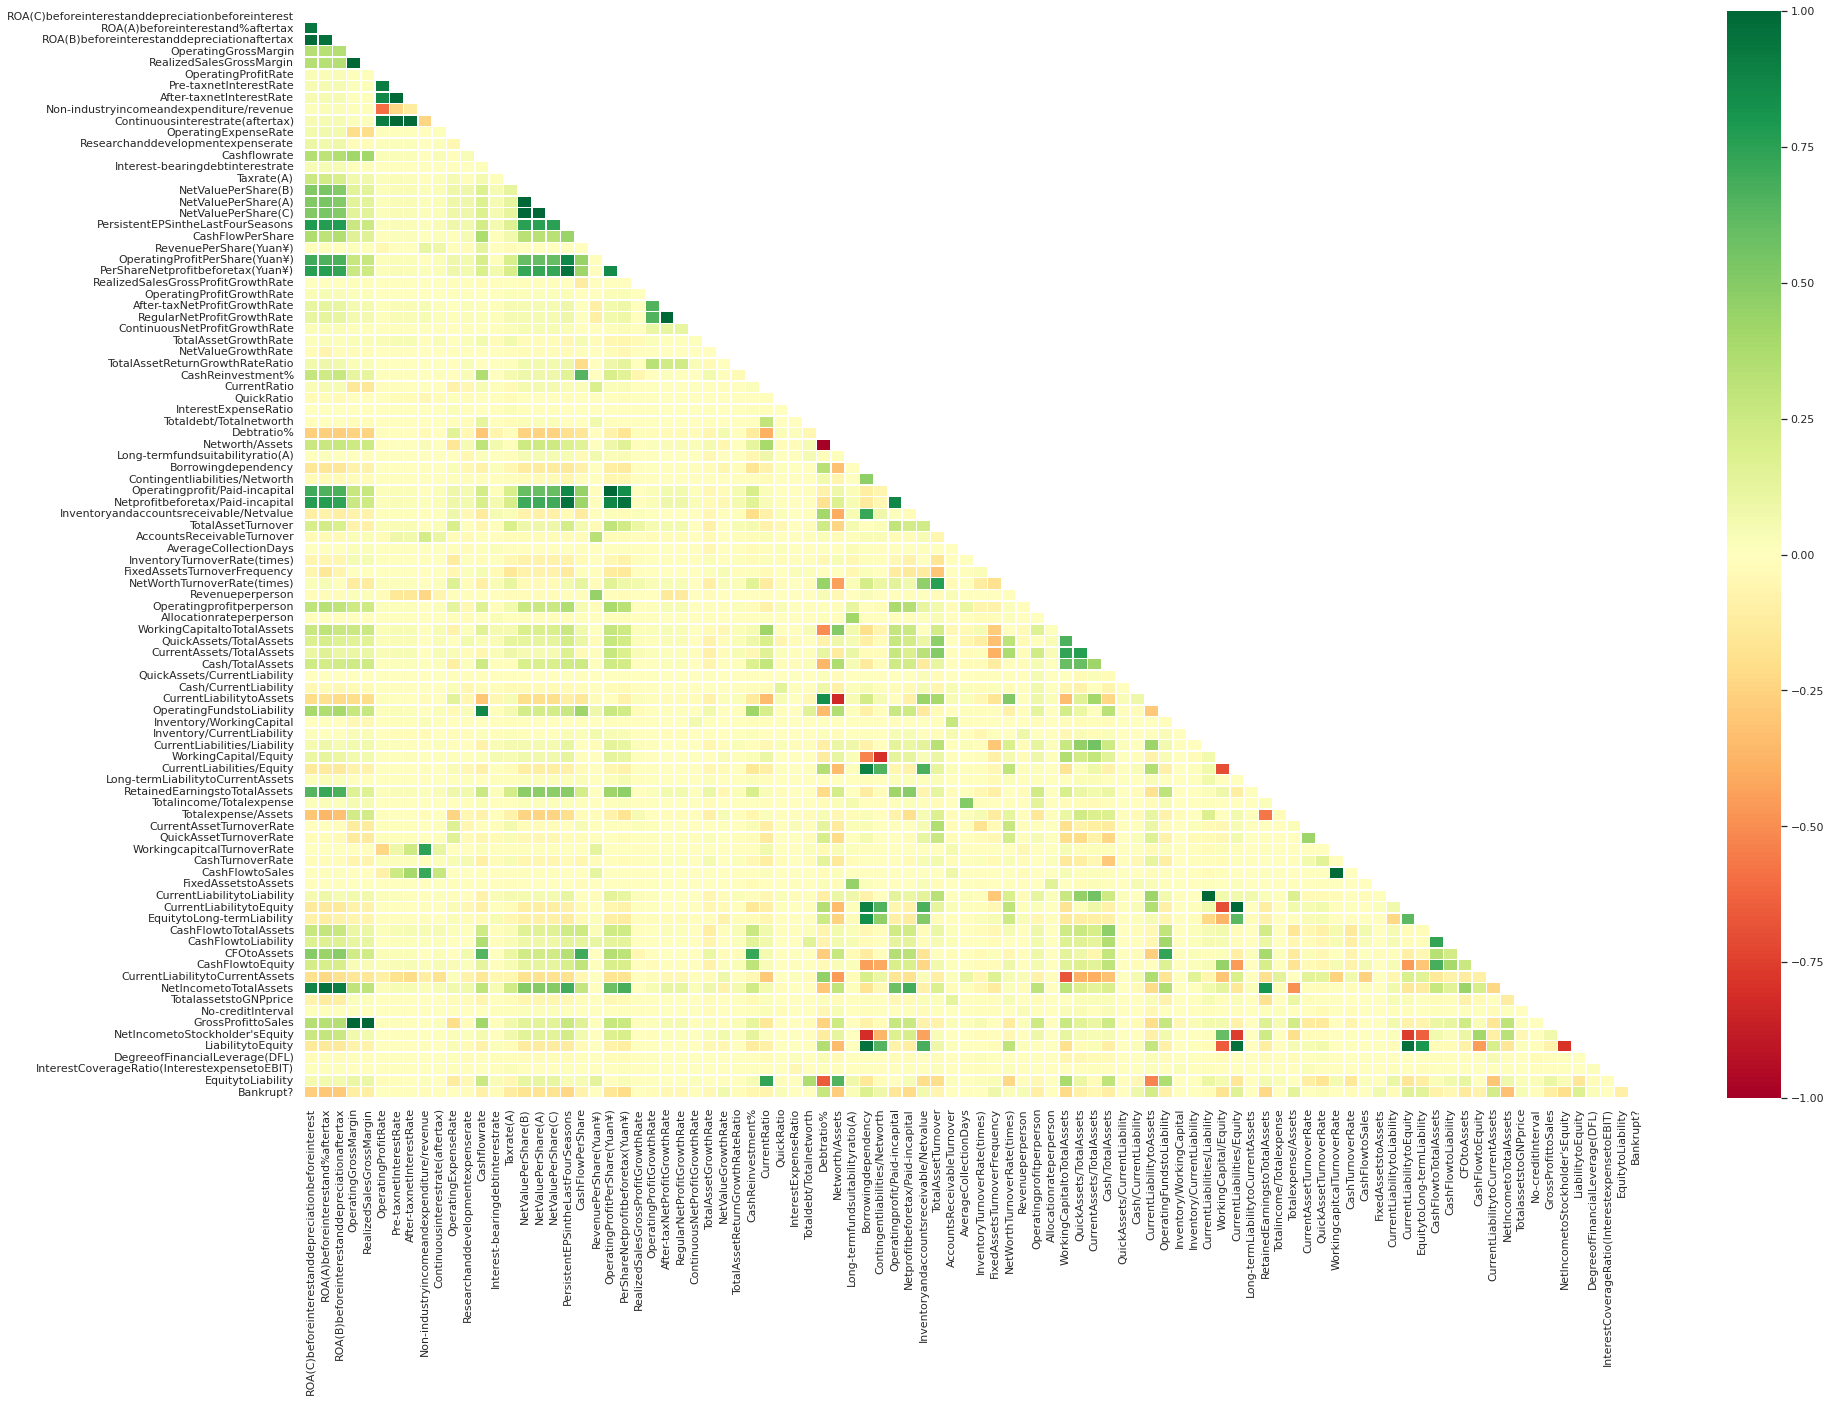

In [18]:
mask_corr_graph(train, columns, fig_size=(30,20), show_corr=False)

In [19]:
train_corr = train.corr()['Bankrupt?'].drop(labels=['Bankrupt?'])
top10_bottom10_corr = train_corr[(train_corr >= train_corr.quantile(q=0.90)) | 
                            (train_corr <= train_corr.quantile(q=0.10))]
top10_bottom10_corr

ROA(C)beforeinterestanddepreciationbeforeinterest   -0.271292
ROA(A)beforeinterestand%aftertax                    -0.294614
ROA(B)beforeinterestanddepreciationaftertax         -0.282967
PersistentEPSintheLastFourSeasons                   -0.228434
PerShareNetprofitbeforetax(Yuan¥)                   -0.210481
Debtratio%                                           0.268030
Networth/Assets                                     -0.268030
Borrowingdependency                                  0.179269
Netprofitbeforetax/Paid-incapital                   -0.217936
WorkingCapitaltoTotalAssets                         -0.212901
Cash/CurrentLiability                                0.089119
CurrentLiabilitytoAssets                             0.213541
CurrentLiabilities/Equity                            0.160984
RetainedEarningstoTotalAssets                       -0.221305
Totalexpense/Assets                                  0.137048
CurrentLiabilitytoEquity                             0.160984
Equityto

In [20]:
top10_bottom10 = list(top10_bottom10_corr.index)

In [26]:
features = cat_num(X_train[top10_bottom10 + cat_features])
cat_features = list(features[0])
num_features = list(features[1])
print(f'''There are {len(features[0])} categorical features.
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features.''')

There are 1 categorical features.
There are 20 numerical features.
There are 0 integer features.


## Pipeline: Preprocesseor

In [7]:
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [8]:
numerical_transformer

Pipeline(steps=[('scaler',
                 <class 'sklearn.preprocessing._data.StandardScaler'>)])

In [9]:
preprocessor = ColumnTransformer(transformers=[
                                               ('numerical', numerical_transformer, num_features),
                                                ('categorical', categorical_transformer, cat_features)
])


NameError: ignored

# Model

## Pipeline: Random Forest Regressor

In [43]:
pipeline = Pipeline(steps= [('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor())
])

In [51]:
# rf_model = pipeline.fit(X_train[top10_bottom10 + cat_features].values, y_train.values)



AttributeError: ignored